In [1]:
from dataclasses import dataclass
import xarray as xr
import rioxarray as xrr
from rioxarray.merge import merge_arrays
import geopandas as gpd
import contextily as cx
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io import img_tiles as cimgt
from shapely.geometry import box

import make_slr_scenario as make_SS

%matplotlib inline
%pdb off

print (os.getenv('CONDA_PROMPT_MODIFIER'), datetime.now())

Automatic pdb calling has been turned OFF
(SL)  2024-10-21 14:32:44.095442


In [2]:
# path_wd = Path('/scratch/tws_grace/data/Sea_Level/SFEI')
path_wd = Path('/Volumes/RADS/NFS/data/Sea_Level/SFEI')

In [3]:
regions = 'South Central North'.split()
# scen = scen0.replace('_rsl', '')
# s2_ext = '_s2' if use_s2 else ''
# vlm_ext = '_vlm' if use_vlm else ''

basemap_d = cimgt.GoogleTiles(url='https://server.arcgisonline.com/ArcGIS/rest/services/Elevation/World_Hillshade_Dark/MapServer/tile/{z}/{y}/{x}.jpg')
basemap   = cimgt.GoogleTiles(url='https://server.arcgisonline.com/arcgis/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}.jpg')
# basemap   = cimgt.GoogleTiles(url='https://www.google.cn/maps/vt?lyrs=s@189&gl=cn&x={x}&y={y}&z={z}'))

cxbasemap   = cx.providers.Esri.WorldImagery
cxbasemap_d = cx.providers.CartoDB.DarkMatter
cxbasemap_t = cx.providers.USGS.USTopo
            
projp = ccrs.PlateCarree()
GFS = GS  = 14 
TFS = 20 # title
XFS = YFS = 16 # x/y axis
GFS = 14 # deg marks
CFS = 18 # colorbar labels

pt_parms  = dict(verticalalignment='top', fontsize=20, color='w',
                bbox=dict(boxstyle='square,pad=0.05', facecolor='black'))

dct_proju = {'Central': ccrs.UTM(10), 'North': ccrs.UTM(10), 'South': ccrs.UTM(11)}

sty_cari   = dict(facecolor='none', edgecolor='deeppink') 

# Plot MLLW / MAH

In [26]:
from BZ import bbPlot
kind, scen, year = 'MLLW', 'Int', 2050
da_mllw0 =  xrr.open_rasterio(path_wd / 'tidal_datums' / f'{kind}_SLR_0.tif').squeeze()
da_mllw_slr =  xrr.open_rasterio(path_wd / 'tidal_datums' / f'{kind}_SLR_{scen}{year}_vlm.tif').squeeze()
sty_mllw = dict(cmap='cmc.vik', norm=mpl.colors.TwoSlopeNorm(0, -0.4, 0.4), shading='nearest', transform=projp)
# w, s, e, n = da_mllw0.rio.bounds()

In [30]:
df = pd.read_csv(path_wd / 'results' / 'Central_beach_Int2050.csv')
df.head()

<xarray.DataArray ()> Size: 4B
array(-0.3619501, dtype=float32)
Coordinates:
    band         int64 8B 1
    spatial_ref  int64 8B 0 <xarray.DataArray ()> Size: 4B
array(0.1129318, dtype=float32)
Coordinates:
    band         int64 8B 1
    spatial_ref  int64 8B 0
<xarray.DataArray ()> Size: 8B
array(-0.5882607)
Coordinates:
    band         int64 8B 1
    spatial_ref  int64 8B 0 <xarray.DataArray ()> Size: 8B
array(1.5866968)
Coordinates:
    band         int64 8B 1
    spatial_ref  int64 8B 0


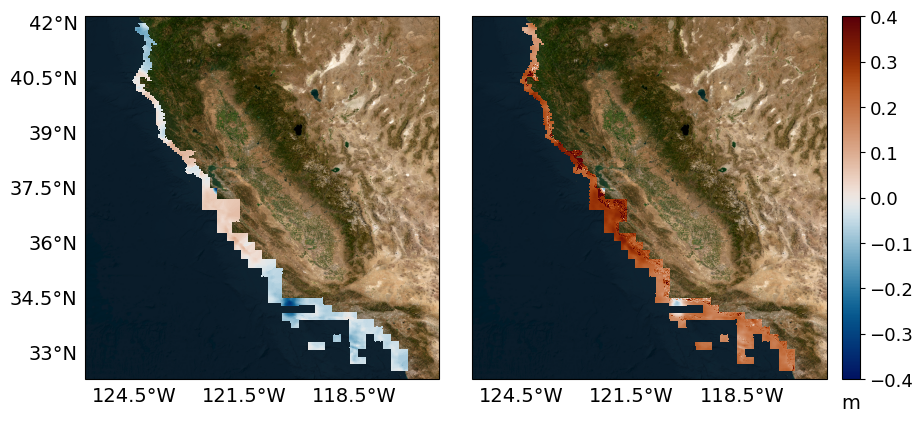

In [29]:
fig, axes = plt.subplots(figsize=(10, 14), ncols=2, subplot_kw={'projection': projp})
for i, da in enumerate([da_mllw0, da_mllw_slr]):
    da = da.rio.reproject(4326).copy()
    da = da.where(da<1e10)
    da.rio.write_nodata(da.rio.nodata, encoded=True, inplace=True)

    im = axes[i].pcolormesh(da.x, da.y, da, **sty_mllw)
    axes[i].add_image(basemap, 10)
    cbar = bbPlot.cartopy_cbar(im, xlabel=('m', GS))
    cbar.ax.set_visible(False) if i == 0 else ''
    left = True if i ==0 else False
    gl = axes[i].gridlines(draw_labels=True)
    bbPlot.fmt_gridlines(gl, left=left, bottom=True, size=GS)

    ## add the regional boundaries 
    gdf = gpd.read_file(path_wd / 'CoastalRegions.GeoJSON').to_crs(4326)
    colors = 'deeppink'
    # South, Central, North
    colors = plt.cm.get_cmap('cmo.matter')
    colors = [colors(0.0), colors(0.25), colors(0.5)]

    # for j in range(gdf.shape[0]):
    #     gser = gdf.iloc[[j]]
    #     gser.plot(ax=axes[i], facecolor='none', edgecolor=colors[j], 
    #               linestyle='--', linewidth=2.25, transform=projp, zorder=50)

    

fig.subplots_adjust(wspace=0.0)
fig.set_label(f'MLLW0_MLLW{scen}{year}')
# bbPlot.savefigs(path_wd, True, True)

# Check SLR Scenario and VLM

In [6]:
da_slr.shape, da_vlm.shape

((3552, 2624), (3552, 2624))

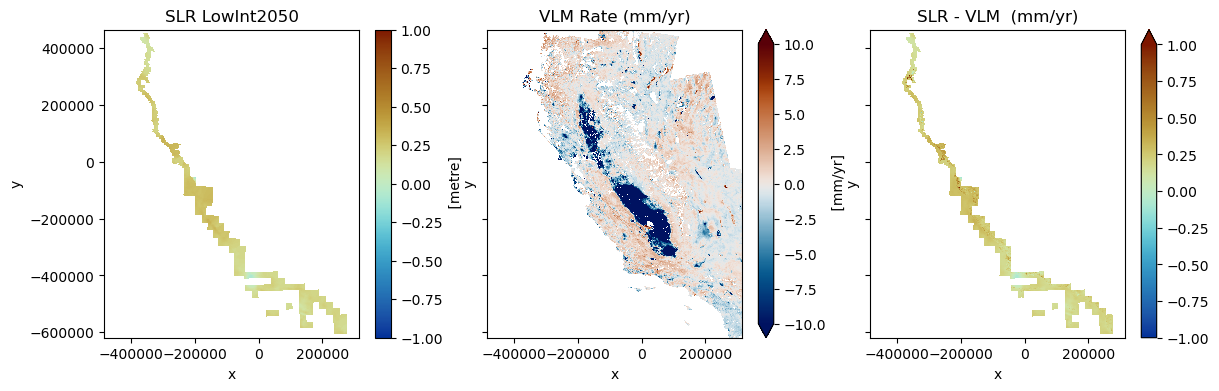

In [4]:
scen1 = 'LowInt2050'
sty_slr = dict(cmap='cmc.roma_r', norm=mpl.colors.Normalize(-1, 1))
sty_vlm = dict(cmap='cmc.vik', norm=mpl.colors.Normalize(-10, 10))

da_slr = xrr.open_rasterio(path_wd / 'tidal_datums' / 'MLLW_SLR_Int2050.tif').sel(band=1)
da_vlm = xrr.open_rasterio(path_wd / 'CA_VLM_MLLW.tif').sel(band=1).assign_attrs(units='mm/yr')
da_vlm = da_vlm.where(da_vlm < 1e20)
da_vlm_2050 = da_vlm * 26 / 1000
da_tot = da_slr - da_vlm_2050.where(~da_vlm.isnull(), 0)

fig, axes = plt.subplots(figsize=(14, 4), ncols=3, sharey=True)
da_slr.plot(ax=axes[0], **sty_slr)
da_vlm.plot(ax=axes[1], **sty_vlm)
da_tot.plot(ax=axes[2], **sty_slr)
axes[0].set_title(f'SLR {scen1}')
axes[1].set_title(f'VLM Rate (mm/yr)');
axes[2].set_title(f'SLR - VLM  (mm/yr)');

# da_resid.plot(ax=axes[2], cmap='cmc.vik', norm=mpl.colors.TwoSlopeNorm(0))


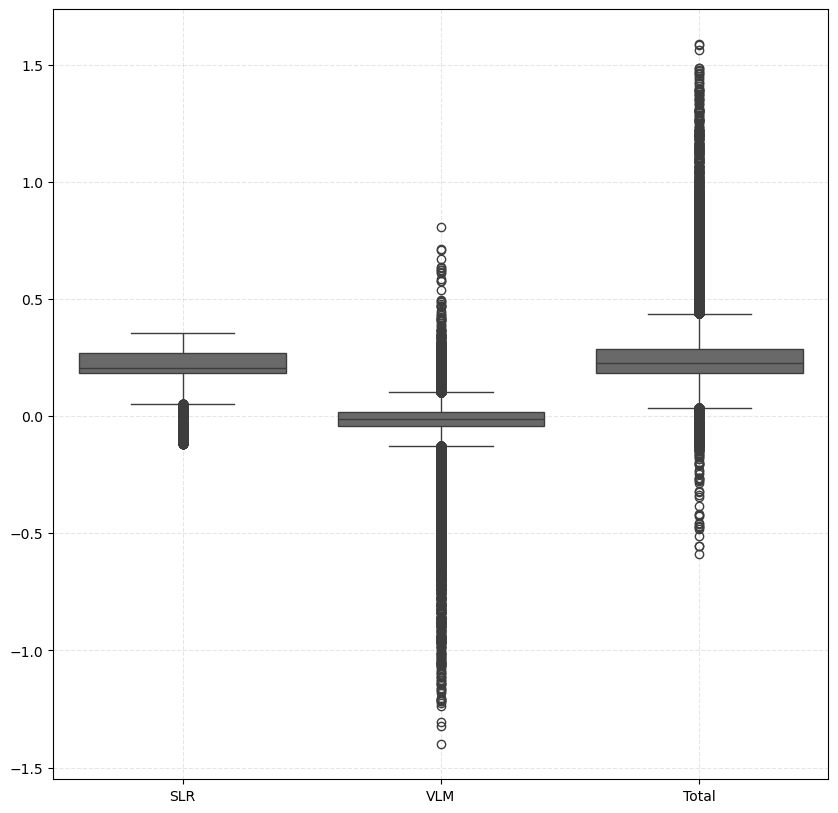

In [31]:
fig, axes = plt.subplots(figsize=(10, 10))

df = pd.DataFrame({'SLR': da_slr.data.ravel(), 'VLM': da_vlm_2050.data.ravel(), 'Total': da_tot.data.ravel()}).dropna()

sns.boxplot(ax=axes, data=df, color='dimgray')
axes.grid(color='k', alpha=0.1, linestyle='--')
                  

In [14]:
from BZ import *
da_mmm(da_tot)

Min | Mean | Max: -0.53 | 0.22 +/- 0.08 | 1.48 


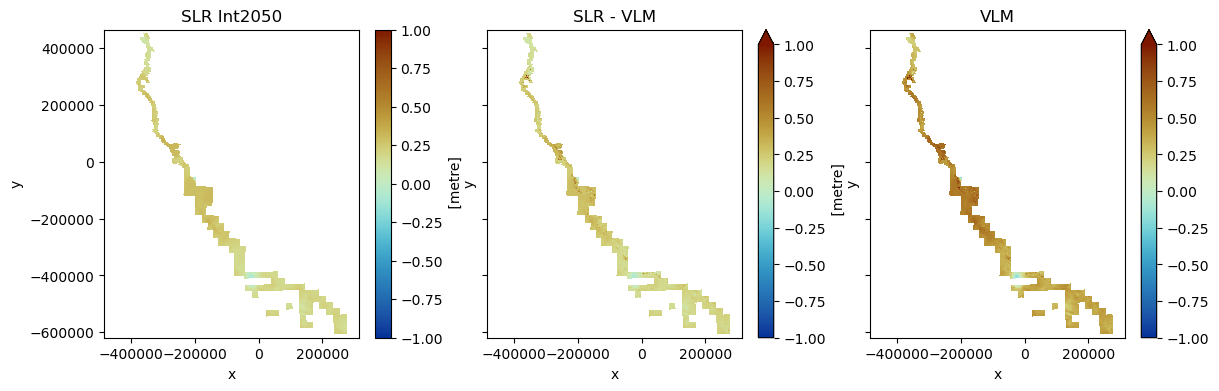

In [9]:
## load the newly created total
scen1 = 'Int2050'
sty_slr = dict(cmap='cmc.roma_r', norm=mpl.colors.Normalize(-1, 1))
sty_vlm = dict(cmap='cmc.vik', norm=mpl.colors.Normalize(-1, 1))

da_slr = xrr.open_rasterio(path_wd / 'tidal_datums' / 'MLLW_SLR_Int2050.tif').sel(band=1)
da_tot = xrr.open_rasterio(path_wd / 'tidal_datums' / 'MLLW_SLR_Int2050_VLM.tif').sel(band=1)
da_vlm = da_tot + da_slr

fig, axes = plt.subplots(figsize=(14, 4), ncols=3, sharey=True)
da_slr.plot(ax=axes[0], **sty_slr)
da_tot.plot(ax=axes[1], **sty_slr)
da_vlm.plot(ax=axes[2], **sty_slr)
axes[0].set_title(f'SLR {scen1}')
axes[1].set_title(f'SLR - VLM')
axes[2].set_title(f'VLM');

# da_resid.plot(ax=axes[2], cmap='cmc.vik', norm=mpl.colors.TwoSlopeNorm(0))
